In [1]:
%run setup.py

In [2]:
t, y = np.loadtxt('../lc/10080943_lc.txt', usecols=(0,1)).T

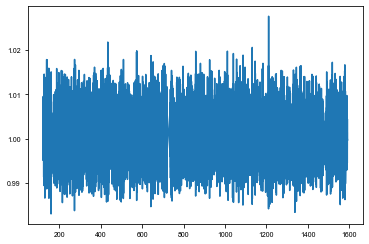

In [3]:
plt.plot(t,y)

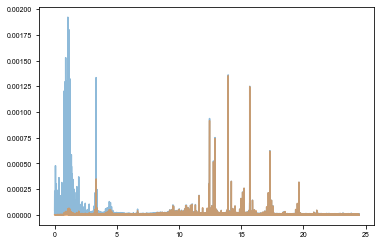

In [4]:
from scipy.ndimage import gaussian_filter
from maelstrom.utils import amplitude_spectrum
y_low = gaussian_filter(y,1.8)
y_high = y - y_low

plt.plot(*amplitude_spectrum(t, y), alpha=0.5)
plt.plot(*amplitude_spectrum(t, y_high), alpha=0.5)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116bd6eb8>,
      dtype=object)

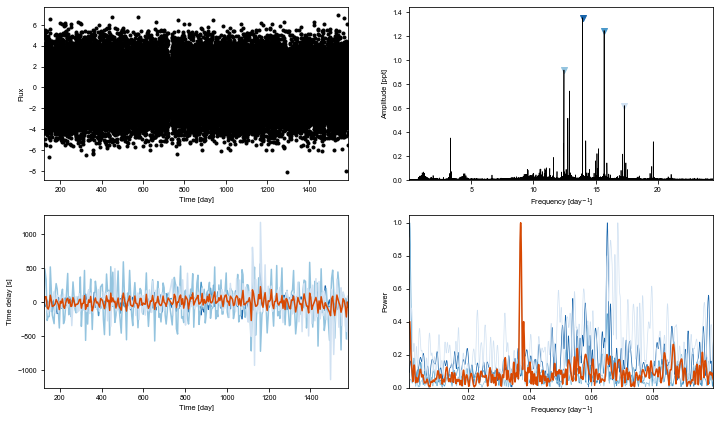

In [5]:
ms = Maelstrom(t, y_high, freq=np.array([13.94758557, 15.68333011, 
                                    12.45257641, 
#                                     12.89053954, 
                                    17.30504092, 
#                                     14.20333404
                                   ]))
ms.first_look(segment_size=5)

In [6]:
freq = ms.freq
time, flux = ms.time, ms.flux

In [7]:
period_guess = 15.334

In [8]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [9]:
import tqdm
t0s = np.arange(time.min(), time.max(), 3.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm.tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], flux[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 420/420 [00:00<00:00, 2405.95it/s]


Text(0, 0.5, 'power')

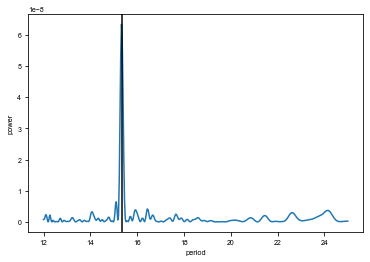

In [10]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], phases[m, 0], min_period=12, max_period=25)
f, p = res["periodogram"]
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")

In [11]:
period_guess = res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess

(15.335878873082686, 43.18400031048696)

# Subdividing model

In [12]:
def dft_phase(x, y, freq):
    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
    return phase

In [13]:
from astropy.stats import LombScargle

freq = ms.freq[:1]
segment_size=4

uHz_conv = 1e-6 * 24 * 60 * 60
time_0 = time[0]
time_slice, mag_slice, phase = [], [], []
time_delays, time_midpoints = [], []

# Iterate over lightcurve
for t, y in zip(time, flux):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        phase.append(dft_phase(time_slice, mag_slice, freq))
        time_0 = t
        time_slice, mag_slice = [], []

phase = np.array(phase).T
# Phase wrapping patch
for ph, f in zip(phase, freq):
    mean_phase = np.mean(ph)
    ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    ph -= np.mean(ph)
#     ph = np.unwrap(ph)
#     ph -= np.mean(ph)

    td = ph / (2*np.pi*(f / uHz_conv * 1e-6))
    time_delays.append(td)
    
weights = ms.get_weights(norm=False)


#|plt.scatter(time_midpoints,np.average(time_delays,axis=0, weights=weights))

td_time, td_td = time_midpoints,np.average(time_delays,axis=0, weights=weights[:1])
#nu_arr = freq
td_time = np.array(td_time)
td_td = np.array(td_td)
# td_time, td_td = np.array(time_midpoints), np.array(time_delays[0])


In [14]:
weights

array([1.34772162, 1.24429097, 0.91763563, 0.61523976])

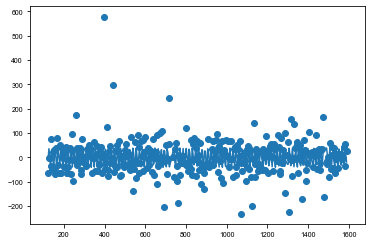

In [17]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1.0, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    mean = pm.Normal('mean', mu=np.median(td_td), sd=5, testval=np.median(td_td))
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=5, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    #drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.4)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    #tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - tt.mean(tau) + mean)
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)

    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.scatter(td_time, td_td)

In [18]:
with subdivide_model:
    map_params = xo.optimize(vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=[omega, eccen])
    map_params = xo.optimize(start=map_params)

optimizing logp for variables: [mean]
5it [00:01,  2.80it/s, logp=-1.276811e+06] 
message: Optimization terminated successfully.
logp: -1277151.0054081937 -> -1276810.5971639934
optimizing logp for variables: [logP]
13it [00:00, 88.30it/s, logp=-9.719662e+05] 
message: Optimization terminated successfully.
logp: -1276810.5971639934 -> -971966.1627903979
optimizing logp for variables: [logasini]
16it [00:00, 83.34it/s, logp=-8.544680e+05] 
message: Optimization terminated successfully.
logp: -971966.1627903979 -> -854468.0445354239
optimizing logp for variables: [eccen, omega]
137it [00:00, 282.98it/s, logp=-8.541406e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -854468.0445354239 -> -854140.5739847843
optimizing logp for variables: [eccen, omega, logasini, logs_lc, phi, mean, logP]
21it [00:00, 116.03it/s, logp=-1.021591e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -854140.5739847843 -> -114780.21445976157


In [19]:
with subdivide_model:
    trace = pm.sample(draws=2000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eccen, omega, logasini, logs_lc, phi, mean, logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [12:15<00:00, 10.88draws/s]  
The acceptance probability does not match the target. It is 0.9187384576573221, but should be close to 0.8. Try to increase the number of tuning steps.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.16236133349742451, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


# RV only

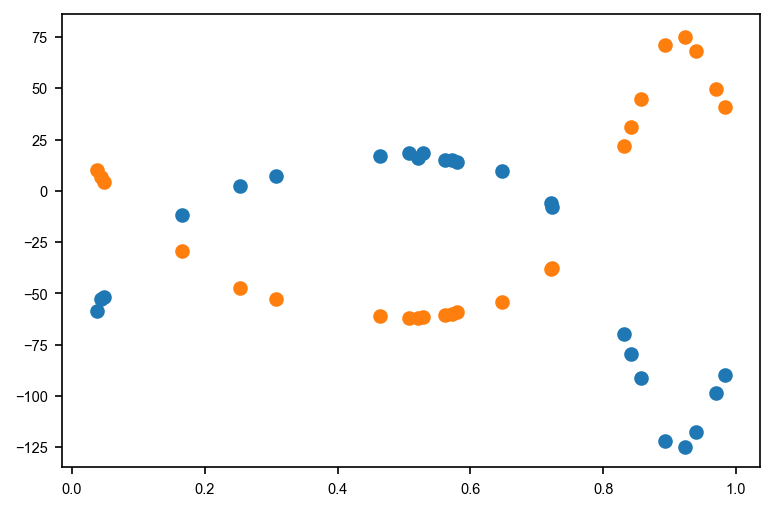

In [22]:
rv_jd_a, rv_rv_a, rv_err_a = np.loadtxt('../data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_a += 2400000
rv_jd_a -= 2454833

rv_jd_b, rv_rv_b, rv_err_b = np.loadtxt('../data/kic10080943b_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_b += 2400000
rv_jd_b -= 2454833

plt.scatter(rv_jd_a % period_guess / period_guess, rv_rv_a)
plt.scatter(rv_jd_b % period_guess / period_guess, rv_rv_b)

In [16]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0, upper=20)("P", mu=period_guess, sd=1,
                                     shape=1, testval=period_guess)

    asini = pm.Normal('asini', mu=np.array([a_guess, -1*a_guess]), sd=5, testval=np.array([a_guess, -1*a_guess]), shape=2)
    
    logs_a = pm.Normal("logs_a", mu=np.log(np.median(rv_err_a)), sd=5.0)
    logs_b = pm.Normal("logs_b", mu=np.log(np.median(rv_err_b)), sd=5.0)
    
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.5)
    omega = xo.distributions.Angle("omega", shape=1)
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=0.)
    phi = xo.distributions.Angle('phi', testval=0.)
    
    orbit_a = Orbit(period=P,
                   lighttime=asini,
                   phi=phi,
                   eccen=ecc,
                   omega=omega)
    vrad_a = orbit_a.get_radial_velocity(rv_jd_a)[:,0] + gammav
    err_a = tt.sqrt(2*rv_err_a**2 + tt.exp(2*logs_a))
    pm.Normal("obs", mu=vrad_a, sd=err_a, observed=rv_rv_a)
 
    vrad_b = orbit_a.get_radial_velocity(rv_jd_b)[:,1] + gammav
    err_b = tt.sqrt(2*rv_err_b**2 + tt.exp(2*logs_b))
    pm.Normal("obs_b", mu=vrad_b, sd=err_b, observed=rv_rv_b)
    
    t = np.linspace(rv_jd_a.min()-5, rv_jd_a.max()+5, 1000)
    fine_grid_a = orbit_a.get_radial_velocity(t) + gammav

In [17]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln, vars=[phi])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
322it [00:01, 205.07it/s, logp=-2.168263e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -681450.5463788682 -> -21.68262962535469
optimizing logp for variables: [gammav]
5it [00:00, 63.38it/s, logp=-2.168263e+01] 
message: Optimization terminated successfully.
logp: -21.68262962535469 -> -21.682629625354622
optimizing logp for variables: [phi]
3it [00:00, 42.23it/s, logp=-2.168263e+01] 
message: Optimization terminated successfully.
logp: -21.682629625354622 -> -21.682629625354622
optimizing logp for variables: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
96it [00:00, 360.59it/s, logp=-2.212767e+01]
message: Desired error not necessarily achieved due to precision loss.
logp: -21.682629625354622 -> -21.682629625354622


In [18]:
map_soln

{'P_interval__': array([1.19038812]),
 'asini': array([ 44.9292204, -43.198366 ]),
 'logs_a': array(-0.16539749),
 'logs_b': array(-1.05667061),
 'ecc_logodds__': array([-0.18874464]),
 'omega_angle__': array([[-1.17601462],
        [ 4.31474094]]),
 'gammav_interval__': array(-0.99170963),
 'phi_angle__': array([-2.7313461 ,  3.54115056]),
 'P': array([15.33620944]),
 'ecc': array([0.45295343]),
 'omega': array([-0.26609394]),
 'gammav': array(-22.94254738),
 'phi': array(-0.65700436)}

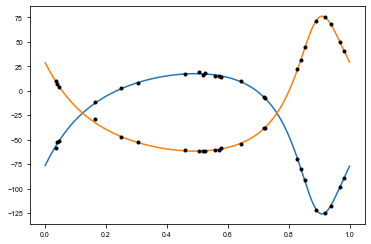

In [20]:
with model:
    fold = t % map_soln['P'] / map_soln['P']
    sort = np.argsort(fold)
    plt.plot(fold[sort], xo.eval_in_model(fine_grid_a, map_soln)[:,0][sort])
    plt.plot(rv_jd_a % map_soln['P'] / map_soln['P'], rv_rv_a,'.k')
    
    
    plt.plot(fold[sort], xo.eval_in_model(fine_grid_a, map_soln)[:,1][sort])
    plt.plot(rv_jd_b % map_soln['P'] / map_soln['P'], rv_rv_b,'.k')

In [21]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=2000, step=xo.get_dense_nuts_step(target_accept=0.95), start=map_soln)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, gammav, omega, ecc, logs_b, logs_a, asini, P]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:35<00:00, 225.12draws/s]


In [22]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini__0,44.924885,0.173424,0.002319,44.579209,45.259325,5496.583279,0.999759
asini__1,-43.194197,0.091308,0.001336,-43.368314,-43.009628,5345.994877,0.999759
logs_a,-0.091387,0.165575,0.002104,-0.416011,0.220438,4851.183366,0.999881
logs_b,-0.852652,0.230484,0.003940,-1.279749,-0.383615,3454.348539,0.999813
P__0,15.336216,0.000178,0.000003,15.335883,15.336577,3260.911780,0.999853
ecc__0,0.453039,0.001636,0.000024,0.450002,0.456456,5022.503137,0.999815
omega__0,-0.266588,0.005529,0.000085,-0.277859,-0.256162,3981.518066,0.999931
gammav,-22.935786,0.092157,0.001381,-23.115612,-22.754384,4348.433787,0.999873
phi,-0.657458,0.010379,0.000190,-0.678072,-0.637912,3111.050305,0.999781


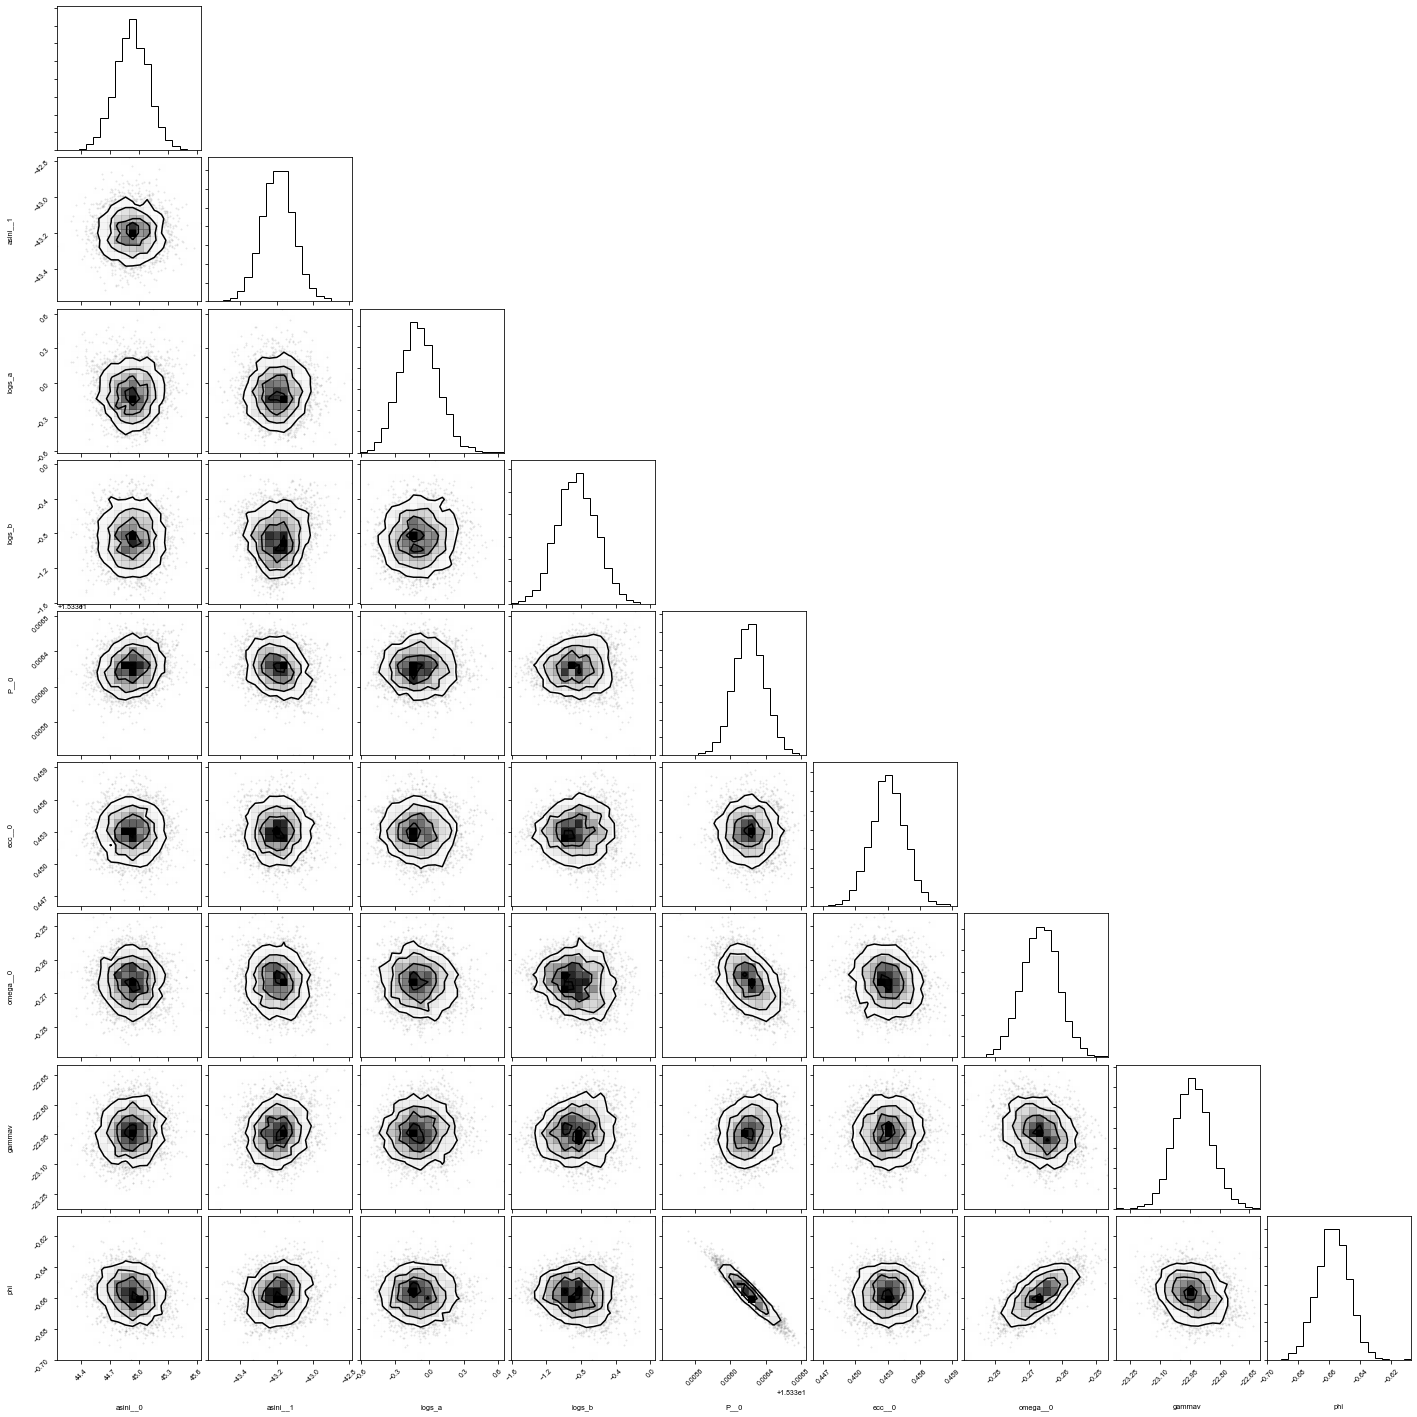

In [23]:
import corner

corner.corner(pm.trace_to_dataframe(trace), smooth=0.1);

## Models

In [12]:
t, y = np.loadtxt('../lc/10080943_lc.txt', usecols=(0,1)).T
ms = Maelstrom(t, y, freq=np.array([13.94758557, 15.68333011, 
                                    12.45257641, 
                                    12.89053954, 
                                    17.30504092, 
                                    14.20333404
                                   ]))

ms.setup_orbit_model(period=period_guess, eccen=0.47)
opt = ms.optimize()

In [13]:
opt

{'logperiod': array(2.73070677),
 't0': array(0.17553471),
 'varpi_angle__': array([0.70773536, 4.41577974]),
 'eccen_interval__': array(-0.02463491),
 'logs': array(1.50528193),
 'lighttime': array([ 53.61586717, -38.8472069 , -33.40936846, -51.56070236,
        -27.87132658,  26.74603238]),
 'mean_flux': array(-1.82195198e-05),
 'W_hat_cos': array([ 1.05634718, -0.39108552,  0.13741333,  0.74102303,  0.31710819,
         0.12761488]),
 'W_hat_sin': array([ 0.85777012, -1.1886997 ,  0.926447  ,  0.11229388, -0.5377217 ,
         0.30426578]),
 'period': array(15.34372761),
 'varpi': array(0.15892256),
 'eccen': array(0.49384171),
 'tref': array(-1.11379176)}

In [14]:
lt = opt['lighttime']

lt_ivar = np.arange(len(ms.freq)).astype(np.int32)
chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
pinned_lt = lt


nu_arr_negative = ms.freq[np.where(inds==1)]
nu_arr_positive = ms.freq[np.where(inds==0)]

In [15]:
pinned_lt

array([ 26.74603238, -37.18333572])

In [16]:
nu_arr_negative

array([15.68333011, 12.45257641, 12.89053954, 17.30504092])

In [17]:
pinned_lt = np.array([45, -45])

In [18]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(opt['period']), sd=10,
                                      testval=np.log(opt['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    
#     a1sini = pm.Normal("a1sini", mu=pinned_lt[0], sd=15, testval=pinned_lt[0])
#     a2sini = pm.Normal("a2sini", mu=pinned_lt[1], sd=15, testval=pinned_lt[1])
    
    asini = pm.Uniform("a1sini", lower=-60, upper=60, testval=0., shape=len(ms.freq))
    
    nu = pm.Normal('nu1', mu=ms.freq, sd=0.001, testval=ms.freq, shape=len(ms.freq))
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=opt['varpi'])
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=opt['eccen'])
    
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu,)
    
    full_lc = orbit.get_lightcurve_model(time, flux) + mean
#     # GP parameters
    logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))

In [19]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    map_params = xo.optimize(start=map_params, vars=[asini])
#     map_params = xo.optimize(start=map_params)

[phi_angle__, logs_lc, a1sini_interval__, nu1, mean, omega_angle__, eccen_interval__, logw0_interval__, logpower]


optimizing logp for variables: [mean]
5it [00:00, 12.33it/s, logp=-9.163158e+04]
message: Optimization terminated successfully.
logp: -91631.58017353232 -> -91631.58016325891
optimizing logp for variables: [logs_lc]
9it [00:00, 13.35it/s, logp=-9.141110e+04]
message: Optimization terminated successfully.
logp: -91631.58016325891 -> -91411.09622039845
optimizing logp for variables: [logw0, logpower]
77it [00:05, 13.02it/s, logp=-8.792164e+04]
message: Optimization terminated successfully.
logp: -91411.09622039845 -> -87921.64120520385
optimizing logp for variables: [omega]
10it [00:00, 12.15it/s, logp=-8.790118e+04]
message: Optimization terminated successfully.
logp: -87921.64120520385 -> -87901.1838824683
optimizing logp for variables: [phi]
10it [00:00, 11.56it/s, logp=-8.788073e+04]
message: Optimization terminated successfully.
logp: -87901.1838824683 -> -87880.72655973278
optimizing logp for variables: [nu1]
73it [00:06, 11.79it/s, logp=-8.788050e+04]
message: Desired error not ne

In [20]:
map_params

{'logP_interval__': array(-0.05248863),
 'phi_angle__': array([-2.47685837,  3.72367927]),
 'logs_lc': array(-0.07325965),
 'a1sini_interval__': array([ 2.55611906, -1.86388101, -1.64838462, -2.76057578, -1.28442251,
         1.54885858]),
 'nu1': array([13.9475854 , 15.68333017, 12.45257685, 12.89054045, 17.30504162,
        14.20333571]),
 'mean': array(-1.57363599e-05),
 'omega_angle__': array([-0.19744059,  4.4676294 ]),
 'eccen_interval__': array(0.18097839),
 'logw0_interval__': array(0.01832139),
 'logpower': array(-18.73810084),
 'logP': array(2.73052251),
 'period': array(15.34090074),
 'phi': array(-0.58696176),
 'a1sini': array([ 51.35802294, -43.88984051, -40.64071292, -52.86094305,
        -33.98419743,  38.96985772]),
 'omega': array(-0.04416485),
 'eccen': array(0.54457639),
 'logw0': array(-0.79336369),
 'logS0': array(-15.56464607)}

In [21]:
lt = map_params['a1sini']

lt_ivar = np.arange(len(ms.freq)).astype(np.int32)
chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
pinned_lt = lt


nu_arr_negative = ms.freq[np.where(inds==1)]
nu_arr_positive = ms.freq[np.where(inds==0)]

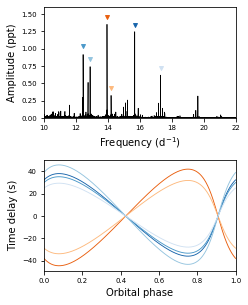

In [22]:
fig, axes = plt.subplots(2,1, figsize=[3.3333,2.06*2], constrained_layout=True)
with model:
    val = xo.eval_in_model(orbit.get_time_delay(time), map_params).T * 86400
    tt_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(tt_time)
from maelstrom.utils import unique_colors

ax = axes[1]
pos_td = val[map_params['a1sini'] > 0]
pos = unique_colors(len(pos_td), cmap='Oranges')[::-1]

neg_td = val[map_params['a1sini'] < 0]
neg = unique_colors(len(neg_td), cmap='Blues')[::-1]

for td, color in zip(pos_td, pos):
    ax.plot(tt_time[sort], td.T[sort], color=color, linewidth=0.9)

for td, color in zip(neg_td, neg):
    ax.plot(tt_time[sort], td.T[sort], color=color, linewidth=0.9)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)')
ax.set_xlim(0,1)

from maelstrom.utils import amplitude_spectrum
ax = axes[0]
f,a = amplitude_spectrum(time, flux)
ax.plot(f,a, linewidth=0.7, c='black')
ax.set_xlim(0,24)
ax.set_ylim(0,1.6)
ax.set_xlabel('Frequency (d$^{-1}$)')
ax.set_ylabel('Amplitude (ppt)')
ax.set_xlim(10,22)
weights = ms.get_weights(norm=False)
pos_freq = ms.freq[map_params['a1sini'] > 0]
pos_weight = weights[map_params['a1sini'] > 0]
neg_freq = ms.freq[map_params['a1sini'] < 0]
neg_weight = weights[map_params['a1sini'] < 0]

for ff, weight, color in zip(pos_freq, pos_weight, pos):
    ax.scatter(ff,weight+0.1,15,color=color, marker='v')
    
for ff, weight, color in zip(neg_freq, neg_weight, neg):
    ax.scatter(ff,weight+0.1,15,color=color, marker='v')
    
# plt.savefig(overleaf_path+'10080943_init_opt.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [21]:
from maelstrom.orbit import Orbit

pinned_lt = [
    44.,
    -44.
]
nu_arr_positive = np.array([
    13.94758524
])
nu_arr_negative = np.array([
    15.68332996, 12.45257786
])

In [22]:
pinned_lt

[44.0, -44.0]

In [23]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(15.34090074), sd=10,
                                      testval=np.log(15.34090074))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    a1sini = pm.Normal('a1sini', mu=pinned_lt[0], sd=10, testval=pinned_lt[0])
    a2sini = pm.Normal('a2sini', mu=pinned_lt[1], sd=10, testval=pinned_lt[1])
    nu1 = pm.Normal('nu1', mu=nu_arr_positive, sd=0.001, testval=nu_arr_positive, shape=len(nu_arr_positive))
    nu2 = pm.Normal('nu2', mu=nu_arr_negative, sd=0.001, testval=nu_arr_negative, shape=len(nu_arr_negative))
    
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=map_params['omega'])
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=map_params['eccen'])
    
    orbit1 = Orbit(period=period, 
                  lighttime=a1sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu1)
    
    orbit2 = Orbit(period=period, 
                  lighttime=a2sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu2)
    
    full_lc = orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean
    
#     # GP parameters
    logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))

NameError: name 'map_params' is not defined

In [ ]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu1, nu2])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
#     map_params = xo.optimize(start=map_params)

In [ ]:
map_params

In [ ]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=1000, 
        draws=2000, 
        step=xo.get_dense_nuts_step(target_accept=0.9), 
        start=map_params
    )
    
pm.save_trace(trace,'traces/NEW/10080943_PM')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logpower, logw0, eccen, omega, mean, nu2, nu1, a2sini, a1sini, logs_lc, phi, logP]
Sampling 4 chains:   5%|▌         | 636/12000 [3:54:04<54:31:01, 17.27s/draws] 

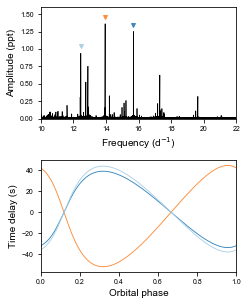

In [47]:
opt = map_params

In [48]:
opt

{'logP_interval__': array(-0.05304152),
 'phi_angle__': array([2.84697063, 3.448891  ]),
 'logs_lc': array(0.27237454),
 'asini_interval__': array([ 1.19710235, -0.8571673 , -0.98050136]),
 'omega_angle__': array([-0.68829479,  4.41884616]),
 'mean': array(-0.04298838),
 'lognu': array([2.63530639, 2.75259836, 2.52192766]),
 'phase_angle__': array([[-1.75645807,  3.17034142,  1.76290606],
        [ 4.11276393,  3.15417836, -4.11000361]]),
 'logamp': array([ 0.30917564,  0.22535038, -0.06669878]),
 'logw0_interval__': array(9.29309804),
 'logpower': array(9.04306205),
 'logP': array(2.73020446),
 'period': array(15.33602234),
 'phi': array(0.69008215),
 'asini': array([ 53.60178129, -40.41369651, -45.44153712]),
 'omega': array(-0.15452177),
 'nu': array([13.94758524, 15.68332996, 12.45257786]),
 'phase': array([-0.40362676,  0.78795378,  2.73639752]),
 'logw0': array(1.14436979),
 'logS0': array(4.4655829)}

In [13]:
pinned_lt = [
    53.60178129,
    -43.
]
nu_arr_positive = np.array([
    13.94758524
])
nu_arr_negative = np.array([
    15.68332996, 12.45257786
])

In [49]:
lt = opt['asini']

lt_ivar = np.arange(len(opt['nu'])).astype(np.int32)
chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
pinned_lt = lt

# Get frequencies for each star
nu_arr_negative = opt['nu'][np.where(inds==1)]
nu_arr_positive = opt['nu'][np.where(inds==0)]

In [58]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as pb2_model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(map_params['period']), sd=10.,
                                      testval=np.log(map_params['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=10, testval=np.log(np.median(np.abs(np.diff(flux)))))
    asini_neg = pm.Normal("asini_pos",mu=pinned_lt[0], sd=20, testval=pinned_lt[0])
    asini_pos = pm.Normal("asini_neg",mu=pinned_lt[1], sd=20, testval=pinned_lt[1])
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.)
    
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.444)
    
    M = 2.0 * np.pi * time / period - phi
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = - (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))
    
    lognu_pos = pm.Normal("lognu_pos", mu=np.log(nu_arr_positive), sd=0.1, shape=len(nu_arr_positive))
    nu_pos = pm.Deterministic("nu_pos", tt.exp(lognu_pos))
    lognu_neg = pm.Normal("lognu_neg", mu=np.log(nu_arr_negative), sd=0.1, shape=len(nu_arr_negative))
    nu_neg = pm.Deterministic("nu_neg", tt.exp(lognu_neg))

    #  Positive
#     arg = 2. * np.pi * nu_pos[None, :] * (time[:, None] - (asini_pos / 86400.) * psi[:, None])
#     W_hat_cos_pos = pm.Normal("W_hat_cos_pos", mu=0.0, sd=100.0,shape=len(nu_arr_positive))
#     W_hat_sin_pos = pm.Normal("W_hat_sin_pos", mu=0.0, sd=100.0,shape=len(nu_arr_positive))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos_pos[:, None]) + tt.dot(tt.sin(arg), W_hat_sin_pos[:, None])
#     lc_model = tt.squeeze(model_tensor)
    
#     #  Negative
#     arg = 2. * np.pi * nu_neg[None, :] * (time[:, None] - (asini_neg / 86400.) * psi[:, None])
#     W_hat_cos_neg = pm.Normal("W_hat_cos_neg", mu=0.0, sd=100.0,shape=len(nu_arr_negative))
#     W_hat_sin_neg = pm.Normal("W_hat_sin_neg", mu=0.0, sd=100.0,shape=len(nu_arr_negative))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos_neg[:, None]) + tt.dot(tt.sin(arg), W_hat_sin_neg[:, None])
#     lc_model += tt.squeeze(model_tensor)

#     # Positive
    arg = 2. * np.pi * nu_pos * (time[:, None] - ((asini_pos) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model = tt.dot(D, w)
    
    # Negative
    arg = 2. * np.pi * nu_neg * (time[:, None] - ((asini_neg) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model += tt.dot(D, w)

    #GP parameters
#     logw0 = logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/1.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
#     full_lc = lc_model + mean
#     gp_l = gp.log_likelihood(flux - full_lc)
#     #Weight likelihood equally with RV data
#     pm.Potential("obs", gp_l)
        
    full_lc = lc_model + mean
    pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)

In [59]:
with pb2_model:
    all_but = [v for v in pb2_model.vars if v.name not in ["logP_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[W_hat_cos_neg, W_hat_cos_pos, W_hat_sin_neg, W_hat_sin_pos])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu_pos, lognu_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini_pos, asini_neg])
    map_params = xo.optimize(start=map_params, vars=[omega, eccen])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)
#     map_params = xo.optimize(start=map_params)

[phi_angle__, logs_lc, asini_pos, asini_neg, mean, omega_angle__, eccen_interval__, lognu_pos, lognu_neg]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -264403.4710434688 -> -264403.4703756111
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -264403.4703756111 -> -191709.93378942844
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -191709.93378942844 -> -191678.5181225986
optimizing logp for variables: ['lognu_neg', 'lognu_pos']
message: Desired error not necessarily achieved due to precision loss.
logp: -191678.5181225986 -> -191678.50112266222
optimizing logp for variables: ['lognu_neg', 'lognu_pos', 'eccen_interval__', 'omega_angle__', 'mean', 'asini_neg', 'asini_pos', 'logs_lc', 'phi_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -191678.50112266222 -> -191678.50112266184
opti

In [60]:
map_params

{'logP_interval__': array(-0.05155323),
 'phi_angle__': array([3.85765665, 2.26240394]),
 'logs_lc': array(1.5181755),
 'asini_pos': array(49.06203725),
 'asini_neg': array(-48.97406846),
 'mean': array(0.0003904),
 'omega_angle__': array([-1.0650696 , -4.34345715]),
 'eccen_interval__': array(-0.0423049),
 'lognu_pos': array([2.63530638]),
 'lognu_neg': array([2.75259833, 2.52192753]),
 'logP': array(2.73106061),
 'period': array(15.3491578),
 'phi': array(1.04038398),
 'omega': array(-2.90112501),
 'eccen': array(0.48893593),
 'nu_pos': array([13.94758513]),
 'nu_neg': array([15.6833294 , 12.45257629])}

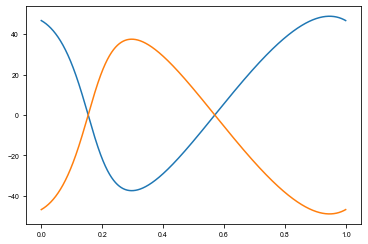

In [61]:
with pb2_model:
    fold_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    
    td_pos = xo.eval_in_model(asini_pos * psi, map_params)
    td_neg = xo.eval_in_model(asini_neg * psi, map_params)
    
    plt.plot(fold_time[sort], td_pos[sort])
    plt.plot(fold_time[sort], td_neg[sort])

## With RV

In [14]:
rv_jd_a, rv_rv_a, rv_err_a = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_a += 2400000
rv_jd_a -= 2454833
rv_jd_a -= ms.time_mid

rv_jd_b, rv_rv_b, rv_err_b = np.loadtxt('data/kic10080943b_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_b += 2400000
rv_jd_b -= 2454833
rv_jd_b -= ms.time_mid

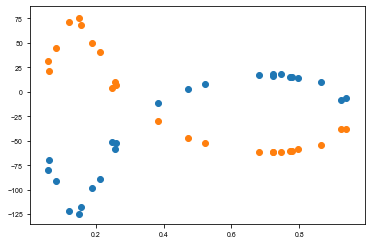

In [15]:
plt.scatter(rv_jd_a % 15.33 / 15.33, rv_rv_a)
plt.scatter(rv_jd_b % 15.33 / 15.33, rv_rv_b)

In [17]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt
import theano

rv_time_tensor_a = theano.shared(rv_jd_a)
rv_rv_tensor_a = theano.shared(rv_rv_a)

rv_time_tensor_b = theano.shared(rv_jd_b)
rv_rv_tensor_b = theano.shared(rv_rv_b)

with pm.Model() as pb2_model_RV:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(15.3356), sd=5.0,
                                      testval=np.log(15.3356))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    asini_pos = pm.Normal("asini_pos",mu=pinned_lt[0], sd=10, testval=pinned_lt[0])
    asini_neg = pm.Normal("asini_neg",mu=pinned_lt[1], sd=10, testval=pinned_lt[1])
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.)
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.444)
    
    M = 2.0 * np.pi * time / period - phi
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = - (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))
    
    lognu_pos = pm.Normal("lognu_pos", mu=np.log(nu_arr_positive), sd=0.1, shape=len(nu_arr_positive))
    nu_pos = pm.Deterministic("nu_pos", tt.exp(lognu_pos))
    lognu_neg = pm.Normal("lognu_neg", mu=np.log(nu_arr_negative), sd=0.1, shape=len(nu_arr_negative))
    nu_neg = pm.Deterministic("nu_neg", tt.exp(lognu_neg))

    # Positive
    arg = 2. * np.pi * nu_pos * (time[:, None] - ((asini_pos) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model = tt.dot(D, w)
    
    # Negative
    arg = 2. * np.pi * nu_neg * (time[:, None] - ((asini_neg) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model += tt.dot(D, w)
        
    # GP parameters
#     logw0 = logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/1.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     gp_l = gp.log_likelihood(flux - full_lc)
#     #Weight likelihood equally with RV data
#     pm.Potential("obs", gp_l)
    
    
    # RADIAL VELOCITIES
    logs_rv_a = pm.Normal('logs_RV_a', mu=0., sd=10)
    logs_rv_b = pm.Normal('logs_RV_b', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    
    # Positive
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor_a / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    rv_vrad_a = ((asini_pos / 86400) * (-2.0 * np.pi * (1 / period) * (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav
    
    # Negative 
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor_b / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    rv_vrad_b = ((asini_neg / 86400) * (-2.0 * np.pi * (1 / period) * (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_b *= 299792.458  # c in km/s
    rv_vrad_b += gammav
    
    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv_a), observed=rv_rv_tensor_a.get_value())
    pm.Normal("obs_radial_velocity_b", mu=rv_vrad_b, sd=tt.exp(logs_rv_b), observed=rv_rv_tensor_b.get_value())
    pm.Normal('obs_lc', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
#     full_lc = lc_model + mean
#     pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)

[phi_angle__, logs_lc, asini_pos, asini_neg, mean, omega_angle__, eccen_interval__, lognu_pos, lognu_neg, logs_RV_a, logs_RV_b, gammav]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -794763.9144321176 -> -794763.9143904693
optimizing logp for variables: ['logs_RV_a', 'logs_lc']
message: Optimization terminated successfully.
logp: -794763.9143904693 -> -223197.9943471864
optimizing logp for variables: ['gammav']
message: Optimization terminated successfully.
logp: -223197.9943471864 -> -220448.23359201144
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -220448.23359201144 -> -196143.84383143304
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -196143.84383143304 -> -196013.9415108297
optimizing logp for variables: ['lognu_neg', 'lognu_pos']
message: Desired error not necessarily achieved due to precision loss.
logp: -

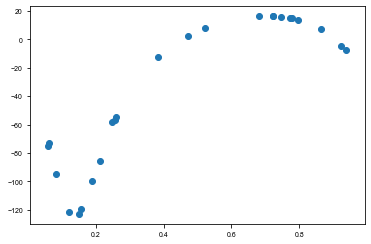

In [28]:
with pb2_model_RV:
    all_but = [v for v in pb2_model_RV.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc, logs_rv_a])
    map_params = xo.optimize(start=map_params, vars=[gammav])
#     map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu_pos, nu_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini_pos, asini_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    plt.scatter(rv_jd_a % 15.33 / 15.33, xo.eval_in_model(rv_vrad_a, map_params))
#     map_params = xo.optimize(start=map_params)

Text(0, 0.5, 'RV (km/s)')

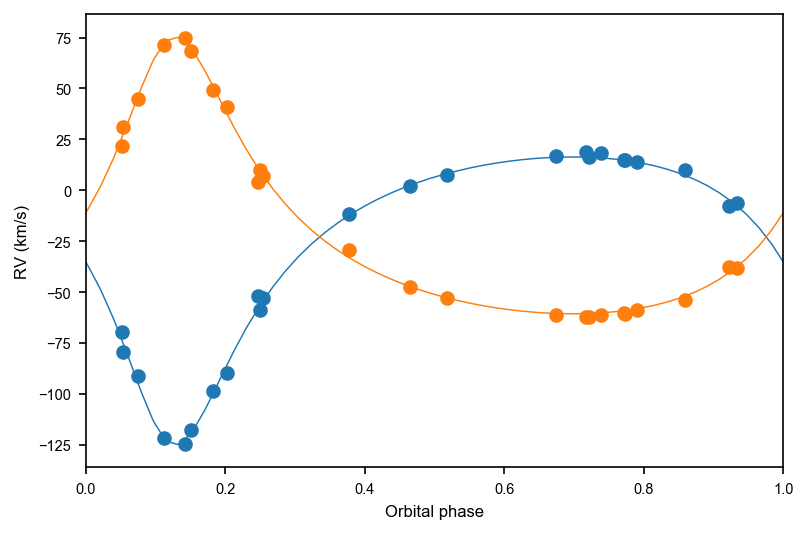

In [43]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a)
    
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b)
    
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

plt.xlim(0,1)
plt.xlabel('Orbital phase')
plt.ylabel('RV (km/s)')

Text(0, 0.5, 'RV (km/s)')

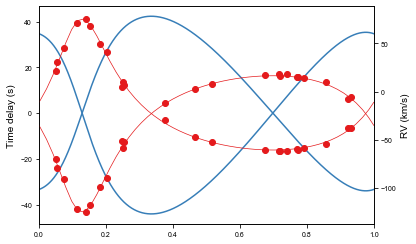

In [30]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    fold_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    
    td_pos = xo.eval_in_model(asini_pos * psi, map_params)
    td_neg = xo.eval_in_model(asini_neg * psi, map_params)
    
    plt.plot(fold_time[sort], td_pos[sort], c=blue)
    plt.plot(fold_time[sort], td_neg[sort], c=blue)
    plt.ylabel('Time delay (s)')
    
    ax2 = plt.twinx()
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    ax2.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7, c=red)
    ax2.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a, c=red)
    
    ax2.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7, c=red)
    ax2.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b, c=red)
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

ax2.set_xlim(0,1)
plt.xlabel('Orbital phase')
ax2.set_ylabel('RV (km/s)')



In [31]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with pb2_model_RV:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [09:20<00:00,  1.36draws/s]


In [33]:
with pb2_model_RV:
    trace = sampler.sample(draws=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs_RV_b, logs_RV_a, lognu_neg, lognu_pos, eccen, omega, mean, asini_neg, asini_pos, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 2000/2000 [19:37<00:00,  1.26draws/s]


In [34]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,1.505374,2.791965e-03,5.074587e-05,1.499990,1.510728,3196.340603,0.999706
asini_pos,44.939928,1.859542e-01,3.730975e-03,44.601160,45.320801,2232.433828,1.003734
asini_neg,-43.164430,1.459248e-01,2.753235e-03,-43.448645,-42.882756,2541.981270,0.999571
mean,-0.000251,1.773215e-02,3.212764e-04,-0.035832,0.033215,3216.097312,0.999866
lognu_pos__0,2.635306,4.902410e-07,9.115598e-09,2.635305,2.635307,2752.307907,0.999522
lognu_pos__1,2.653477,1.992874e-06,3.438912e-08,2.653473,2.653481,3053.138780,0.999506
lognu_neg__0,2.752598,4.675916e-07,9.811853e-09,2.752598,2.752599,2820.092555,0.999541
lognu_neg__1,2.521927,8.056798e-07,1.400438e-08,2.521926,2.521929,3137.253595,0.999674
lognu_neg__2,2.556494,9.788879e-07,1.822999e-08,2.556492,2.556496,3193.144832,0.999993
lognu_neg__3,2.850998,8.970943e-07,1.743723e-08,2.850996,2.851000,3013.964584,0.999838


In [18]:
with pb2_model_RV:
    trace = pm.load_trace('traces/10080943_rv')

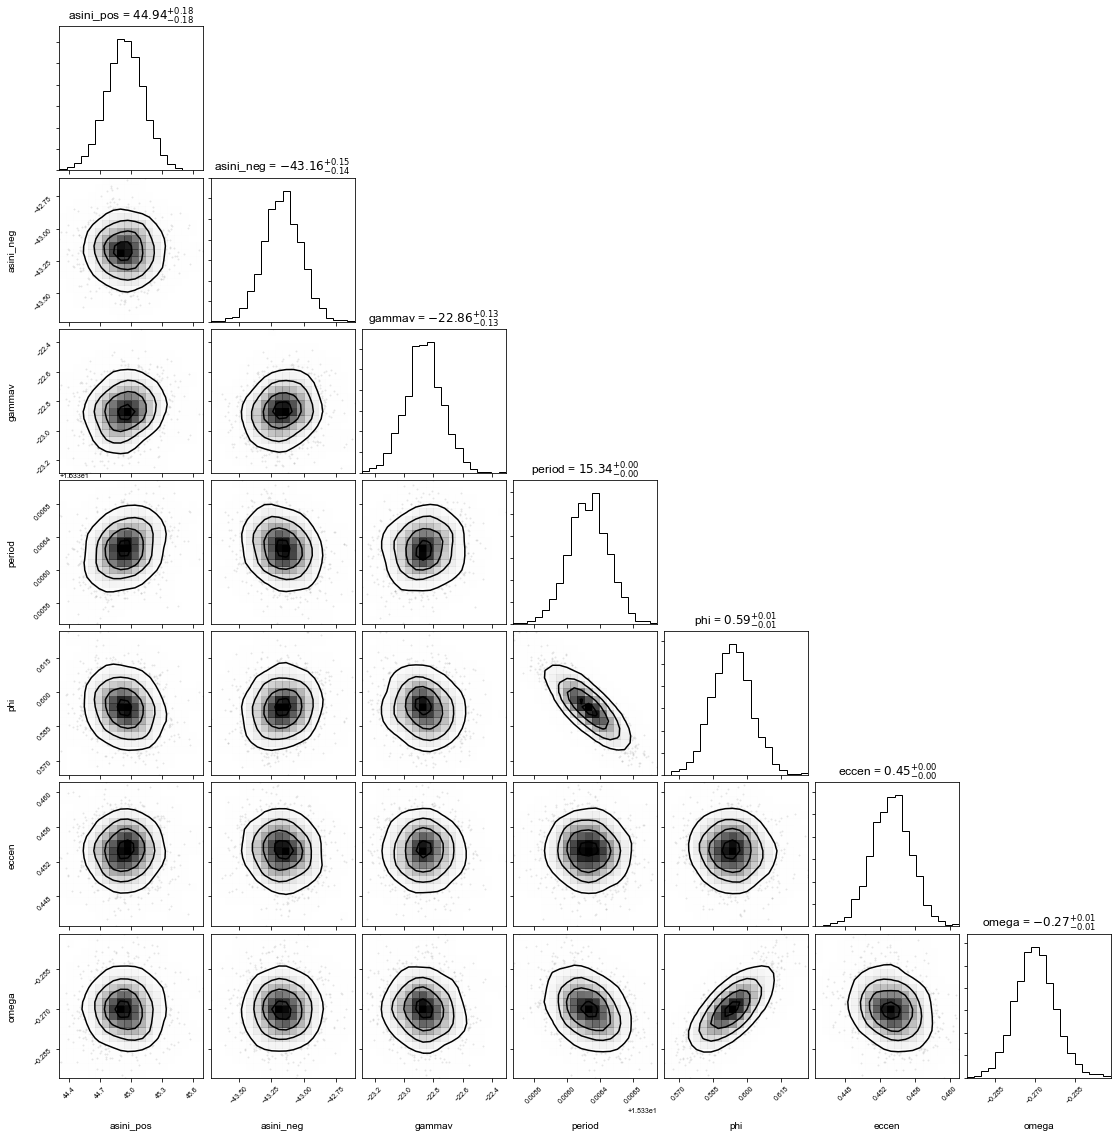

In [19]:
import corner

corner.corner(pm.trace_to_dataframe(trace, 
                                    varnames=['asini_pos', 'asini_neg', 'gammav','period','phi','eccen','omega']),
             smooth=1,
             show_titles=True);

# plt.savefig('10080943.png', dpi=300,bbox_inches='tight')

In [20]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini_pos'])
mfs = mass_function(samples['period'].values * u.day, samples['asini_pos'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.414  +  0.005  -  0.005


In [21]:
varnames=['period', 'asini_pos','asini_neg', 'phi', 'eccen', 'omega','gammav']
rounding = 4
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  15.3363  +  0.0002  -  0.0002
asini_pos :  44.9399  +  0.1817  -  0.1792
asini_neg :  -43.1641  +  0.1465  -  0.1441
phi :  0.5933  +  0.0084  -  0.0088
eccen :  0.4532  +  0.0023  -  0.0022
omega :  -0.2701  +  0.0076  -  0.0075
gammav :  -22.8639  +  0.1282  -  0.1298


In [28]:
with pb2_model_RV:
    a = xo.eval_in_model(asini_pos * psi)

In [27]:
samp

{'logP_interval__': -0.05302221292474968,
 'phi_angle__': array([2.38077305, 3.50810861]),
 'logs_lc': 1.503106224196015,
 'asini_pos': 44.947949539218946,
 'asini_neg': -43.173468198233785,
 'mean': 0.003932298023283192,
 'omega_angle__': array([-1.33818057,  4.99958407]),
 'eccen_interval__': -0.19096305685863374,
 'lognu_pos': array([2.63530587, 2.65347761]),
 'lognu_neg': array([2.75259784, 2.52192862, 2.55649459, 2.85099771]),
 'logs_RV_a': 0.11236832140087478,
 'logs_RV_b': -0.3777195088913156,
 'gammav': -22.825830993916206,
 'logP': 2.7302155683426648,
 'period': 15.336192661233353,
 'phi': 0.5962519902387579,
 'omega': -0.2615280360501543,
 'eccen': 0.45195138464403606,
 'nu_pos': array([13.94757791, 14.20334656]),
 'nu_neg': array([15.68332182, 12.45258985, 12.89055135, 17.3050386 ])}

TypeError: ('Bad input argument to theano function with name "/Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:46" at index 8 (0-based). ', 'Non-unit value on shape on a broadcastable dimension.', (2,), (True,))

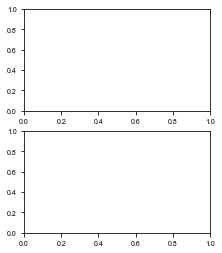

In [22]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

fig, axes = plt.subplots(2,1, figsize=[3.33333,2*2.06])

with pb2_model_RV:
    for samp in xo.utils.get_samples_from_trace(trace, size=300):
        taumod_pos = xo.eval_in_model(asini_pos * psi, samp)
        taumod_neg = xo.eval_in_model(asini_neg * psi, samp)
        ttime = (time) % samp['period'] / samp['period']
        
        sort = np.argsort(ttime)
        
        ax = axes[0]
        ax.plot(ttime[sort], (taumod_pos - np.mean(taumod_pos))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True, zorder=1)
        ax.plot(ttime[sort], (taumod_neg - np.mean(taumod_neg))[sort], color=orange, linewidth=0.1, alpha=1, rasterized=True, zorder=1)
        
        ax = axes[1]
        fold_time = rv_time_tensor_a.get_value() % samp['period'] / samp['period']
        sort = np.argsort(fold_time)
        ax.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, samp)[sort], linewidth=0.1, color=blue)

        ax.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, samp)[sort], linewidth=0.1, color=orange)
        
ax.plot(rv_jd_b % samp['period'] / samp['period'], rv_rv_b, '.k', c=[0.91372549, 0.36862745, 0.05098039])
ax.plot(rv_jd_a % samp['period'] / samp['period'], rv_rv_a, '.k',  c=[0.21568627, 0.52941176, 0.75424837])

axes[1].set_xlabel('Orbital phase')
axes[0].set_ylabel('Time delay (s)')
axes[1].set_ylabel('RV (km/s)')
axes[0].set_xticks([])

axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

plt.subplots_adjust(hspace=0.03)
# plt.savefig(overleaf_path + '10080943.png', dpi=300, bbox_inches='tight', pad_inches=0)

rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

In [96]:
unique_colors(2, cmap='Blues')

array([[0.67189542, 0.81437908, 0.90065359],
       [0.21568627, 0.52941176, 0.75424837]])

In [95]:
orange

'#ff7f00'

In [68]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a)
    
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b)
    
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

<Quantity 3086663.147568 km>